<a href="https://colab.research.google.com/github/guscldns/PoD2DiC/blob/main/Total_Flow_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 이미지 detecting

### importing

In [ ]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import datasets, layers, models
from PIL import Image
#dir(tf.keras.applications)
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

### model bring-in to set up

In [ ]:
model = ResNet50(include_top=True, input_shape = (224, 224 ,3), weights = 'imagenet')

102967424/102967424 [==============================] - 1s 0us/step


### image load-up

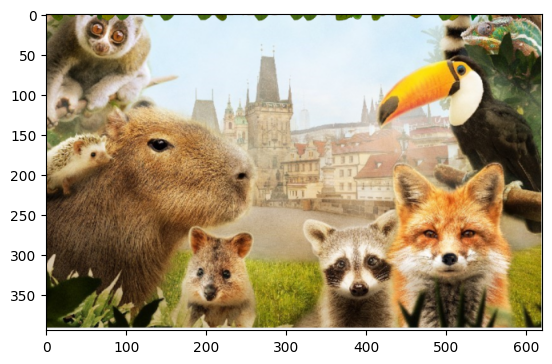

In [ ]:
file_path = '/content/ani.png'
image = Image.open(file_path)
plt.imshow(image)

In [ ]:
# min-pooling 함수 정의
def minpool2d(input_data, pool_size):


    input_height, input_width, input_channels = input_data.shape
    pool_height, pool_width = pool_size

    output_height = input_height // pool_height
    output_width = input_width // pool_width

    pooled_output = np.zeros_like(input_data)

    for h in range(output_height):
        for w in range(output_width):
            start_h = h * pool_height
            end_h = start_h + pool_height
            start_w = w * pool_width
            end_w = start_w + pool_width

            pooled_output[start_h:end_h, start_w:end_w, :] = np.min(input_data[start_h:end_h, start_w:end_w, :], axis=(0, 1))

    return pooled_output

### detecting 함수 정의

In [ ]:
def detection(image, overwrap = 0.75, window_div_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], top_score_k = -1, top_k = 5):
# image : input 이미지 데이터
# window_div_list : 윈도우 사이즈 분위수(예. 4로 할 시 이미지 사이즈)  -> 리스트로 넣어준다. 한개만 넣더라도. default 값은  [1,2,4,8]
# top_score_k : detection함수 종료 시 score 높은 순으로 몇 개 키워드를 출력할지  (default는 끝까지 출력 [:-1])   -> int값 넣어준다.
# stride : 윈도우 이동시길 step(픽셀단위임)  -> int값 넣어준다.
# top_k : 윈도우 별로 모델이 예측한 결과에서 확률이 가장 높은 top_k개를 가져온다.  -> int값 넣어준다. default 값은 5

    chk_img = np.array(image).reshape(1,np.array(image).shape[0],np.array(image).shape[1],np.array(image).shape[2])
    max_img = tf.keras.layers.MaxPool2D((3,3), strides = 1, padding='same')(chk_img)
    max_img = np.array(max_img)[0]

    min_img = minpool2d(chk_img[0], (3,3))

    check_image = 255 - (max_img - min_img)
    check_image = np.where(check_image>240, 255, 0)
    count = 0

    result = {}
    Ydim, Xdim = image.size
    best_window = []

    for window_div in tqdm(window_div_list):

        # X/Y중 더 긴 길이를 window_div로 나눈것이 window size다
        window_size = int(Xdim*window_div)
        stride = int(window_size*(1-overwrap))

        for w in range(0, Xdim - window_size + 1, stride):
            for h in range(0, Ydim - window_size + 1, stride):
                count += 1
                print(count, '번 들어옴')
                check_cropped = check_image[h:window_size + h, w:window_size + w , : ]
                if np.std(check_cropped/255) < 0.2:
                    continue

                img_cropped = image.crop((h, w, window_size + h, window_size + w))
                img_re = np.array(img_cropped.resize((int(224), int(224)),resample = Image.ANTIALIAS))
                input_img = np.expand_dims(img_re, axis=0)
                predictions = model.predict(input_img)
                predicted_class = tf.keras.applications.resnet50.decode_predictions(predictions, top=top_k)

                for i in range(top_k):

                    key = predicted_class[0][i][1]
                    value = predicted_class[0][i][2]
                    if predicted_class[0][i][2] >= 0.90:     # 00퍼센트 이상값이 나온 이미지는 따로 저장
                        best_window.append(img_re)
                        print("찾음 !! ")
                    # score = value / (window_div)**2
                    #score = (np.log(1-value)*(-1))**2 / (window_div)**2
                    if key in result:
                        if result[key] < value:
                            result[key] = value
                    else:
                        result[key] = value

        result = dict(sorted(result.items(), key=lambda x:x[1], reverse=True)[:top_score_k])
    return result, best_window

## 번역 함수 정의

In [ ]:
def translator(keywords_list):
    text = ", ".join(keywords_list)
    url = "https://deepl-translator.p.rapidapi.com/translate"

    payload = {
        "text": text,
        "source": "EN",
        "target": "KO"
    }
    headers = {
        "content-type": "application/json",
        "X-RapidAPI-Key": "42117d1d8emsh2587e836a39e252p130868jsn9d5d74311338",
        "X-RapidAPI-Host": "deepl-translator.p.rapidapi.com"
    }

    response = requests.post(url, json=payload, headers=headers)
    result = response.json()['text']
    return result

In [ ]:
#test
translator(['apple', 'keyboard'])

'사과, 키보드'

### peom generator 생성


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model and tokenizer
model_name_or_path = "ddobokki/gpt2_poem"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
poet_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
poet_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51202, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51202, bias=False)
)

In [ ]:
def poet(input, tokenizer, poet_model):

    keyword_start_token = "<k>"
    keyword_end_token = "</k>"
    text = input
    input_text = keyword_start_token + text + keyword_end_token

    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    gen_ids = poet_model.generate(
        input_ids, max_length=64, num_beams=100, no_repeat_ngram_size=2
    )
    generated = tokenizer.decode(gen_ids[0, :].tolist(), skip_special_tokens=True)
    return generated

In [ ]:
# poet("사과, 키보드 그리고 음악", tokenizer, poet_model)
# 이런식으로 인풋 폼을 정해줘도 좋을듯. keyword1, keyword2 그리고 keyword3 이런식으

## 출력


In [ ]:
# 이미지 디텍팅

result, best_window = detection(image,
                                overwrap = 0.75,
                                top_score_k = 20,
                                window_div_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
                                top_k = 10)

  0%|          | 0/7 [00:00<?, ?it/s]

1 번 들어옴


InvalidArgumentError: ignored

In [ ]:
# 0.2까지
result

{'remote_control': 0.9862077,
 'computer_keyboard': 0.95748985,
 'iron': 0.886397,
 'matchstick': 0.8317974,
 'laptop': 0.83016086,
 'folding_chair': 0.82572436,
 'binder': 0.82508177,
 'crutch': 0.7458401,
 'golfcart': 0.7315458,
 'abacus': 0.72639513,
 'desk': 0.7216356,
 'notebook': 0.7120831,
 'lighter': 0.7073524,
 'joystick': 0.6839941,
 'crossword_puzzle': 0.65654564,
 'screw': 0.6552353,
 'pick': 0.63455087,
 'Loafer': 0.5915493,
 'sock': 0.56716925,
 'mouse': 0.547427}

In [ ]:
# 0.3까지
result

{'remote_control': 0.9862077,
 'matchstick': 0.8317974,
 'laptop': 0.7549144,
 'computer_keyboard': 0.7478761,
 'desk': 0.6936896,
 'binder': 0.670877,
 'crossword_puzzle': 0.65654564,
 'notebook': 0.5992766,
 'crutch': 0.57141453,
 'iron': 0.5019138,
 'lab_coat': 0.45536622,
 'mouse': 0.423666,
 'library': 0.38895658,
 'abacus': 0.38664457,
 'golfcart': 0.3732606,
 'grand_piano': 0.31064543,
 'trombone': 0.28237033,
 'folding_chair': 0.27358574,
 'pick': 0.2653337,
 'barbershop': 0.23629627}

In [ ]:
# 0.4까지 best score
result

{'laptop': 0.7549144,
 'computer_keyboard': 0.71674997,
 'crossword_puzzle': 0.65654564,
 'desk': 0.63093114,
 'notebook': 0.5992766,
 'remote_control': 0.5478576,
 'binder': 0.45010042,
 'mouse': 0.423666,
 'library': 0.38895658,
 'abacus': 0.38664457,
 'golfcart': 0.2826491,
 'folding_chair': 0.27358574,
 'iron': 0.2671893,
 "potter's_wheel": 0.22551984,
 'desktop_computer': 0.21261635,
 'lab_coat': 0.20373952,
 'grand_piano': 0.18831398,
 'crutch': 0.185081,
 'dishwasher': 0.15375029,
 'photocopier': 0.13874261}

In [ ]:
# window_div_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.5]
result

{'zebra': 0.9996238,
 'matchstick': 0.9694262,
 'torch': 0.9280033,
 'candle': 0.90554094,
 'maypole': 0.90476704,
 'starfish': 0.8901413,
 'leatherback_turtle': 0.7406289,
 'carousel': 0.7295059,
 'letter_opener': 0.583186,
 'triceratops': 0.52743083,
 'piggy_bank': 0.47946355,
 'lighter': 0.38769245,
 'oxcart': 0.38382345,
 'West_Highland_white_terrier': 0.3476402,
 'rhinoceros_beetle': 0.30984953,
 'fountain': 0.3032869,
 'flagpole': 0.27619207,
 'lampshade': 0.25791955,
 'lynx': 0.2567808,
 'sulphur-crested_cockatoo': 0.24645348}

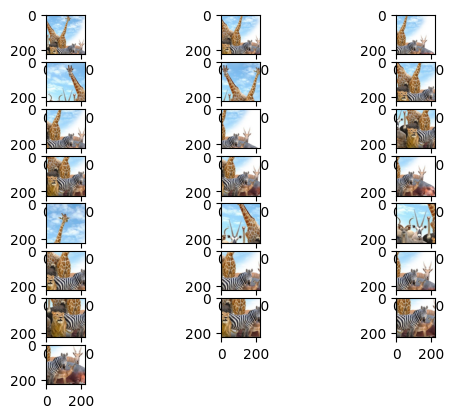

In [ ]:
# 확률높은 window 이미지 시각화
k= len(best_window)
for idx, best_img in enumerate(best_window):
    plt.subplot(k//3+1, 3, idx+1)
    plt.imshow(best_img)

In [ ]:
# 디텍팅 결과로 시 뽑기~

n = 3   # 이미지에서 추출한 키워드 중 사용할 개수
keywords = list(result.keys())[:n]

kor_keywords = translator(keywords)

poem = poet(kor_keywords, tokenizer, poet_model)

print(type(poem))
print(poem)

<class 'str'>
얼룩말, 성냥개비, 횃불 얼룩말
희끄무레한 성냥개비에도
횃불이 환하게 켜지길래
그냥 놔두었더니
어느새 불이 꺼져버렸네
그래도 괜찮아
가만히 지켜보고 있자니


To do further
1. 최종 시 출력시 제목 구분 및 노이즈 제거 후처리
2. TTS

In [ ]:
!pip install gTTS

In [ ]:
from gtts import gTTS

In [ ]:
if __name__ == '__main__':
    sText = poem

    tts = gTTS(text=sText, lang='ko', slow = False)
    sSaveFile = "test_intro.mp3"
    tts.save(sSaveFile)
    print(sSaveFile +"file saved")

test_intro.mp3file saved
